# Effect of UBI on poverty by race

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import microdf as mdf

In [2]:
mdf.set_plot_style()

## Load data

In [3]:
COLS = ['spm_resources', 'spm_povthreshold', 'marsupwt', 'spm_numper',
        'prdtrace']
cps_raw = pd.read_csv('~/datarepo/pppub19.csv.gz',
                      usecols=[col.upper() for col in COLS])

## Preprocess

In [4]:
cps = cps_raw.copy(deep=True)
cps.columns = cps.columns.str.lower()
cps['w'] = cps.marsupwt / 100

In [5]:
cps['race'] = np.where(cps.prdtrace == 1, 'White',
                       np.where(cps.prdtrace == 2, 'Black', 'Other'))

In [6]:
cps['black'] = cps.race == 'Black'

## Baseline

In [7]:
def pov_by_race(df):
    df['poor'] = df.spm_resources < df.spm_povthreshold
    mdf.add_weighted_metrics(df, 'poor', 'w')
    res = df.groupby('race')[['poor_m', 'w_m']].sum()
    return res.poor_m / res.w_m

## UBI

In [8]:
def new_pov(ubi_pp_pm):
    reform = cps.copy(deep=True)
    reform['ubi'] = ubi_pp_pm * reform.spm_numper * 12
    reform.spm_resources += reform.ubi
    return pov_by_race(reform)

In [9]:
UBIS = np.arange(0, 1001, 20)

In [10]:
ubi_pov = pd.DataFrame({'ubi_pm': UBIS})

In [11]:
ubi_pov[['black', 'other', 'white']] = ubi_pov.apply(
    lambda row: new_pov(row.ubi_pm), axis=1)

Calculate deltas.

In [12]:
ubi_pov['black_minus_white'] = ubi_pov.black - ubi_pov.white
ubi_pov['black_div_white'] = ubi_pov.black / ubi_pov.white

## Graphs

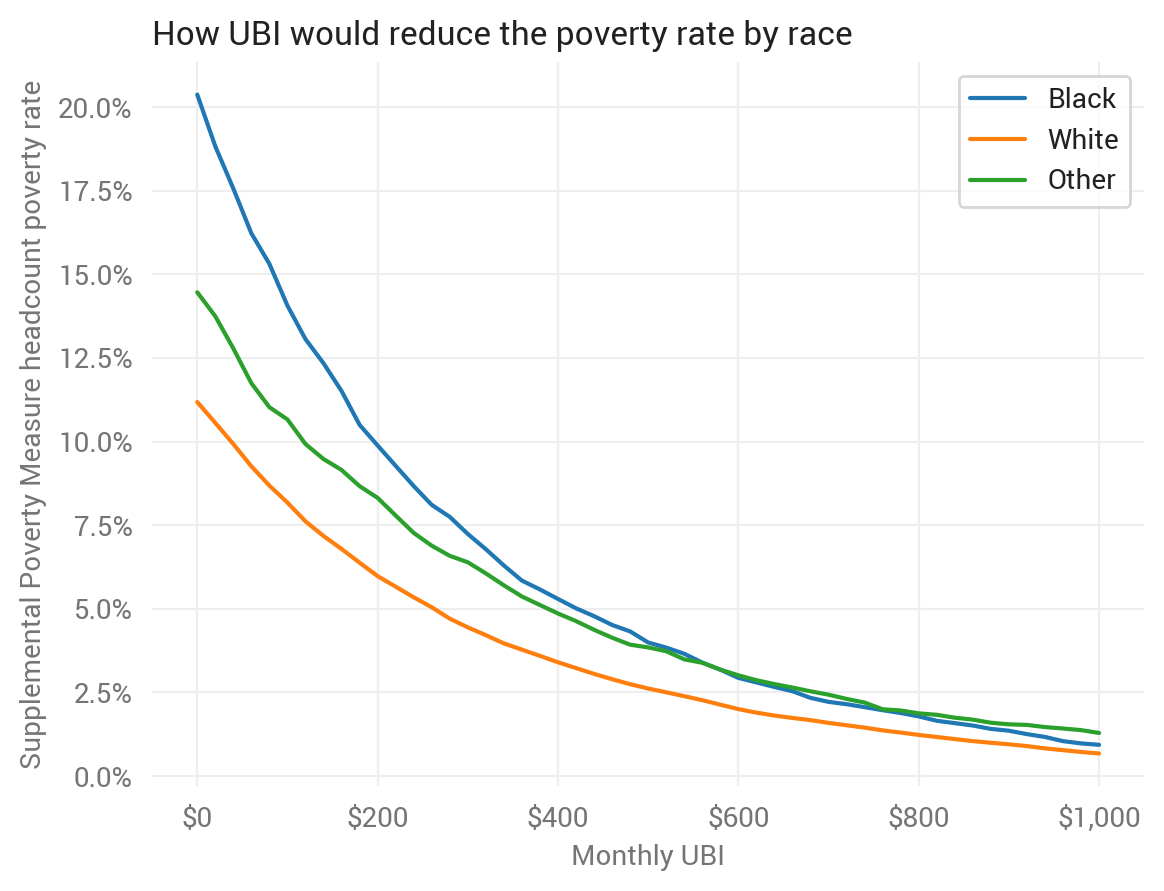

In [13]:
ax = ubi_pov.plot(x='ubi_pm', y=['black', 'white', 'other'])
plt.title('How UBI would reduce the poverty rate by race', loc='left')
plt.legend(['Black', 'White', 'Other'])
plt.xlabel('Monthly UBI')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('Supplemental Poverty Measure headcount poverty rate')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
plt.show()

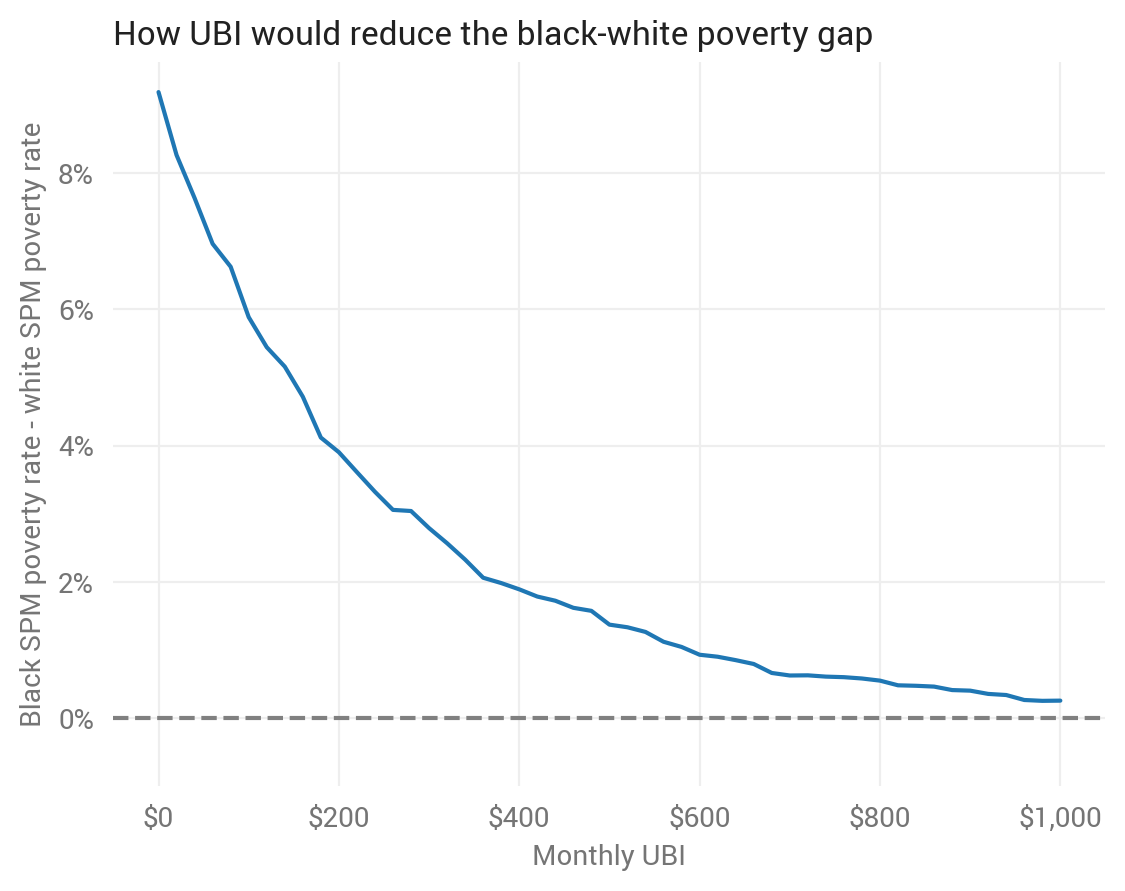

In [14]:
ax = ubi_pov.plot(x='ubi_pm', y='black_minus_white')
plt.title('How UBI would reduce the black-white poverty gap', loc='left')
ax.get_legend().remove()
plt.ylim(-0.01, None)
plt.axhline(0, c='gray', ls='--')
plt.xlabel('Monthly UBI')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('Black SPM poverty rate - white SPM poverty rate')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.show()

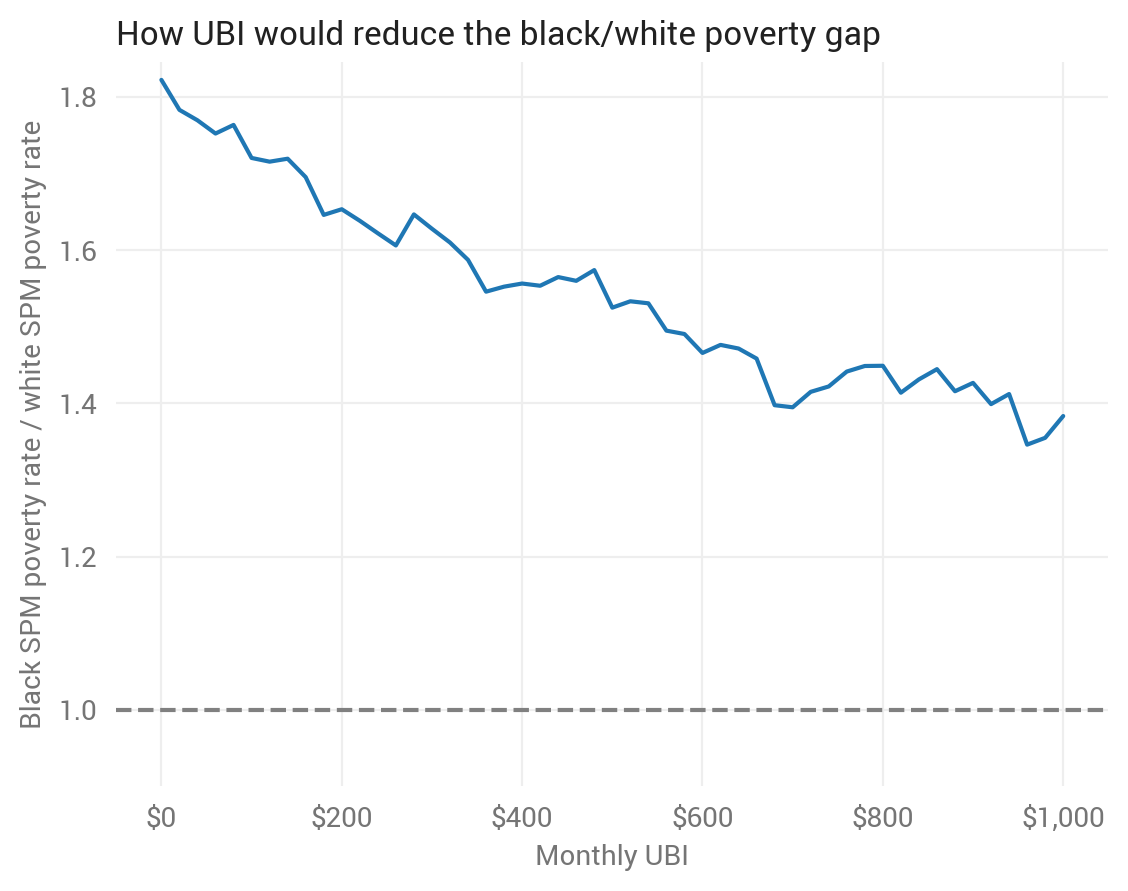

In [15]:
ax = ubi_pov.plot(x='ubi_pm', y='black_div_white')
plt.title('How UBI would reduce the black/white poverty gap', loc='left')
plt.ylim(0.9, None)
plt.axhline(1, c='gray', ls='--')
ax.get_legend().remove()
plt.xlabel('Monthly UBI')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('Black SPM poverty rate / white SPM poverty rate')
plt.show()